<a href="https://colab.research.google.com/github/sherifmost/Topology_Mapping/blob/main/Topology_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **About the project**

This is an assignment in the information systems and software course. As simulating large scale network experiments requires lots of physical resources, partitioning can be used. Topology mapping is a partitioning technique that maps the simulated nodes to different physical nodes. In this assignment, we will use spectral clustering to partition a given network topology on the available physical nodes. 

# **What is a network topology?**

The network topology is a graph of N nodes communicating with each other by sending data traffic through a set of edges. An edge in the topology is weighted by the traffic (Mbps) passing through it. *Our clustering technique should find the cut that minimizes the traffic between different partitions(can be modelled as a minimum cut problem).* 

# **About the data**



*   Data set has 30 network topologies with 3 topology sizes (10,50,100 simulated nodes).
*   Each topology is in a .txt file, where each line is an edge in form <from, to, traffic>.


*   Ground truth custering is available for topologies with size 10 and 50, there is a line for each topology ordered by the topology name t_10_0,t_10_1 .. t_50_9. File name is ground_truth.txt.
*   The ground truth line consists of N values (number of nodes), where nodes having the same value are in the same cluster. ie: corresponding clustering labels.





# **Required Library imports**

In [ ]:
from google.colab import drive
# used to manipulate the folders containing the images and read them out
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as lg 
# to be used in spectral clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
# the libraries used for the evaluation of the clusters
import math
# these libraries are used for visualizing the network topology
import networkx as nx
import matplotlib.colors as colors

# **Labels and Constants**

In [ ]:
# file paths and file names
data_path = '/content/drive/MyDrive/Information systems/Assignment 2/Dataset';

# the three defined topology sizes
top_small = 10;
top_medium = 50;
top_large = 100;

# defined total number of topologies for each size
top_total = 10;

# the constant delimeters and strings
name_sep = '_';
top_prefix = 't';
delim = '/';
read = 'r';

# some colors for visualizing the topology


# extensions
ext_txt = '.txt';

# **Helper functions**

## Helper functions for visualization

In [ ]:
# This function takes in the labels and returns corresponding node colors
# it contains some equations to obtain various colors
def get_node_colors(cluster_labels):
  col_nodes = [];
  # numbers corresponding to rgb should be between 0 and 1 and randomized
  # initialize random numbers corresponding to length of cluster_labels for correctness
  # in any case as it adds a little overhead
  r = np.random.rand(cluster_labels.shape[0]);
  g = np.random.rand(cluster_labels.shape[0]);
  b = np.random.rand(cluster_labels.shape[0]);
  for label in cluster_labels: 
    label = int(label)
    col_nodes.append((r[label],g[label],b[label]));
  return col_nodes;

In [ ]:
# This function takes the labels and edges and returns corresponding edge colors
def get_edge_colors(cluster_labels,graph_edges):
  edge_colors = [];
  for edge in graph_edges:
    # make intracluster edge green
    if cluster_labels[edge[0]] == cluster_labels[edge[1]]:
      edge_colors.append('g');
    # make intercluster edge red
    else:
      edge_colors.append('r');
  return edge_colors;

# **Obtaining the data and cleaning it**

In [ ]:
# I uploaded the data to google drive as a zip file in order use it here
# Mounting the drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Reading the topologies from the corresponding text file

In [ ]:
# size is the corresponding topology size
# top_num is the chosen topology number from 0 to 9 corresponding to the 10 topologies
def read_topology(size,top_num):
  # the topology is implemented as an adjacency matrix of shape n x n where n is number of nodes in the topology
  topology = np.zeros(shape=(size,size),dtype=int);
  # obtaining the file path then reading it line by line to build the topology matrix
  file_path = data_path + delim + top_prefix + name_sep + str(size) + name_sep + str(top_num) + ext_txt;
  top_file = open(file_path,read);
  lines = top_file.readlines();
  for line in lines:
    # parsing the line to obtain the entry
    line_sep = line.split();
    node_from,node_to,weight = [int(line_sep[0]),int(line_sep[1]),int(line_sep[2])];
    # the graph is undirected so 2 entries should be added for the line
    # wights are added beacuse after inspecting the data set, we found that several
    # entries may correspond to connecting the same two nodes.
    topology[node_from - 1][node_to - 1] += weight;
    topology[node_to - 1][node_from - 1] += weight;
  return topology;

In [ ]:
# this function is for convinience to read all the topologies of a given size
def read_top_all(size):
  topologies = [];
  for i in range(top_total):
    topologies.append(read_topology(size,i));
  return np.array(topologies);

# **Visualizing the topology**


These function use the networkx library to visualize the topology

In [ ]:
# given the topology adjacency matrix, an optional title and an optional 
# array of corresponding node cluster labels for annotation in case of having partitioned the topology network
def draw_topology(topology_adj,topology_title = 'Visualizing topology',cluster_labels = [],fig_size=(15,7)):
  # initializing the nodes to be in same cluster in case no clustering happened
  if len(cluster_labels) == 0:
    cluster_labels = np.zeros(shape=(topology_adj.shape[0]));
  # defining a suitable plot size
  plt.figure(figsize = fig_size);
  G = nx.Graph(topology_adj);
  # added to prevent the nodes from being congested in one point as much as possible
  layout = nx.circular_layout(G);
  # adding in the edge labels
  edge_labels = nx.get_edge_attributes(G,'weight')
  nx.draw_networkx_edge_labels(G, pos = layout, edge_labels= edge_labels);
  # adding in the nodes labels numbered conviniently from 1 to size of topology
  # we map each  node to its corresponding label, so x-1 is mapped to x where node labels is a 
  # dictionary.
  node_labels = {x - 1  : x for x in range(1,topology_adj.shape[0] + 1)};
  nx.draw_networkx_labels(G, pos = layout, labels = node_labels,font_color='w',font_weight = 'bold'); 
  # in case clusters were added, we annotate the topology network accordingly
  col_nodes = get_node_colors(cluster_labels);
  col_edges = get_edge_colors(cluster_labels,G.edges);
  # completing the drawing with the corresponding edges and nodes
  nx.draw_networkx_nodes(G, pos = layout, node_color = col_nodes)
  nx.draw_networkx_edges(G, pos = layout, edge_color = col_edges)
  plt.title(topology_title,fontsize = 18);
  plt.show();
  plt.close();

# **Topology mapping**

## Function that obtains the laplacian matrix

In [ ]:
# given the adjacency matrix representing the topology
def get_laplacian(topology):
  # summing the weights for each node to obtain its degree (ie: summing on each row)
  delta = np.sum(topology,axis=1);
  # converting delta to the diagonal form as in the pseudo code of the spectral clustering
  delta = np.diag(delta);
  # laplacian matrix
  L = delta - topology;
  # the asymmetric laplacian matrix
  # delta is symmetric, may be singular so pinv is used
  L_a = lg.pinv(delta,hermitian=True) @ L;
  return L_a;

## Functions implementing the spectral clustering based on the minimum cut

Note that the Kmeans algorithm wasn't implemented from scratch but is used from Sklearn.

In [ ]:
# As obtaining the eigen values and eigen vectors is independent of the number of clusters.
# they are implemented in a separate function to be run once.
# This function returns the eigen vectors in order of increasing eigen values
def eig_vec_spec(topology):
  L = get_laplacian(topology);
  # no known gurantee that L_a is symmetric so eig is used
  eig_val,eig_vec = lg.eig(L);
  sorted_indeces = eig_val.argsort();
  eig_val = eig_val[sorted_indeces];
  eig_vec[:,sorted_indeces];
  return eig_vec;

In [ ]:
# given the eigen vectors from previous part, this part completes the spectral clustering for K clustsers
def spectral_cluster(eig_vec,K):
  # obtaining first K eigen vectors (make sure to take the real parts)
  U = np.real(eig_vec[:,:K]);
  # No normalization done as it is required to minimize the emulated traffic which corresponds to minimum cut
  Y = U;
  # note that KMeans starts with random means so different runs may lead to different clusters
  # we can use an int in the random state to make the randomization deterministic 
  km = KMeans(n_clusters=K);
  cluster_labels = km.fit_predict(Y);
  return cluster_labels;

# **Evaluation**

## External evaluation

### Conditional entropy function

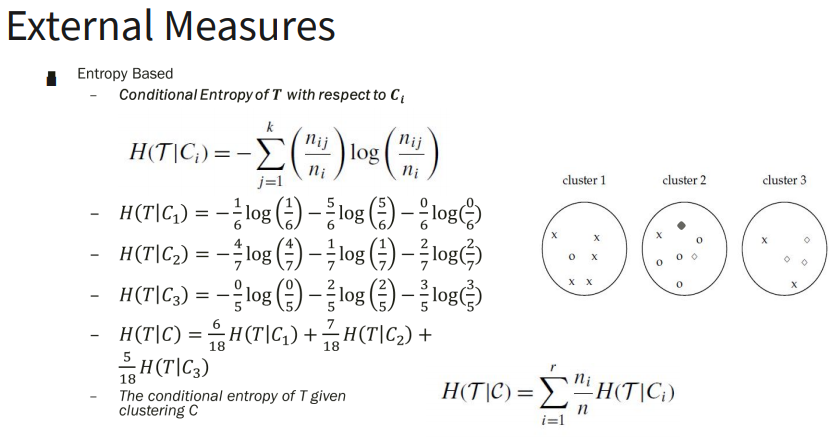

In [ ]:
def conditional_entropy(cluster_labels,true_labels):
  cluster_labels = np.array(cluster_labels);
  true_labels = np.array(true_labels);
  # obtaining the number of clusters in both cases
  # Assuming clusters begin with 0
  n_cluster = np.amax(cluster_labels) + 1;
  n_true = np.amax(true_labels) + 1;
  # This array has the rows representing the cluster labels and the columns representing the true label
  # each entry represents the number of cluster labels appearing corresponding to a true label
  # ie: if node i has a true label of 0 and a cluster label of 1 we add 1 to entry (1,0) meaning that
  # the true label 0 appeared once more corresponding to the label 1
  true_cluster_map = np.zeros((n_cluster,n_true),dtype=int);
  for i in range(cluster_labels.shape[0]):
    true_cluster_map[cluster_labels[i],true_labels[i]] += 1;
  # to obtain the total entropy, we calculate the entropy per row 
  # where probability of a true label in a cluster is the corresponding 
  # entry divided by the sum of the row representing total entries in a cluster
  print(true_cluster_map);
  entropy = 0;
  for curr_cluster in true_cluster_map:
    total_elements = np.sum(curr_cluster);
    curr_entropy = 0;
    for curr_entry in curr_cluster:
      if curr_entry != 0:
        curr_entropy -= (curr_entry/total_elements) * (math.log2((curr_entry/total_elements)));
    entropy += curr_entropy * (total_elements) / cluster_labels.shape[0];
  return entropy;

### F-Measure function

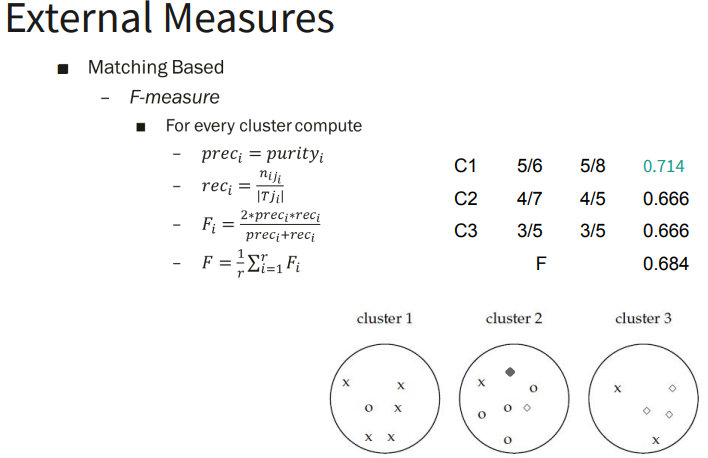

In [ ]:
# given the true labels and the cluster labels
def f_measure(cluster_labels,true_labels):
  cluster_labels = np.array(cluster_labels);
  true_labels = np.array(true_labels);
  n_cluster = np.amax(cluster_labels) + 1;
  n_true = np.amax(true_labels) + 1;
  # obtaining same approach to see how many of a label are present in a cluster
  true_cluster_map = np.zeros((n_cluster,n_true),dtype=int);
  for i in range(cluster_labels.shape[0]):
    true_cluster_map[cluster_labels[i],true_labels[i]] += 1;
  # obtaining the total f measure by calculating it for each row and adding
  f = 0;
  for curr_cluster in true_cluster_map:
    # obtaining the majority entry which is the true label appearing the most in the cluster
    majority_idx = np.argmax(curr_cluster);
    curr_total = np.sum(curr_cluster);
    # obtaining the purity and recall for that index (majority label)
    purity = curr_cluster[majority_idx] / curr_total;
    # obtaining the total number of entries corresponding to this label in the true labels
    total_label = np.sum(true_cluster_map[:,majority_idx],axis = 0);
    recall = curr_cluster[majority_idx] / total_label;
    curr_f = (2 * purity * recall)/(purity + recall);
    f += curr_f / n_cluster;
  return f;

## Internal evaluation

### Normalized-Cut evaluation function

In [ ]:
# given the cluster labels

# **Scripts to run the functions and obtain required outputs**

## Reading the topologies

In [ ]:
top_10 = read_top_all(top_small);
top_50 = read_top_all(top_medium);
top_100 = read_top_all(top_large);

## Visualizing a topology network before clustering 

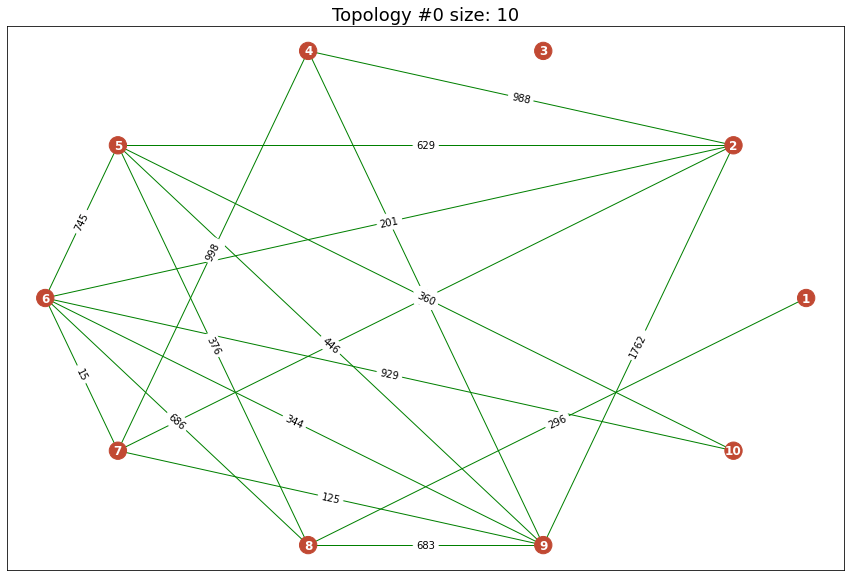

In [ ]:
draw_topology(top_10[0],'Topology #0 size: 10',fig_size=(15,10));

## Visualizing the network after clustering

***Note that a random cluster is used just to test the visualization output.***

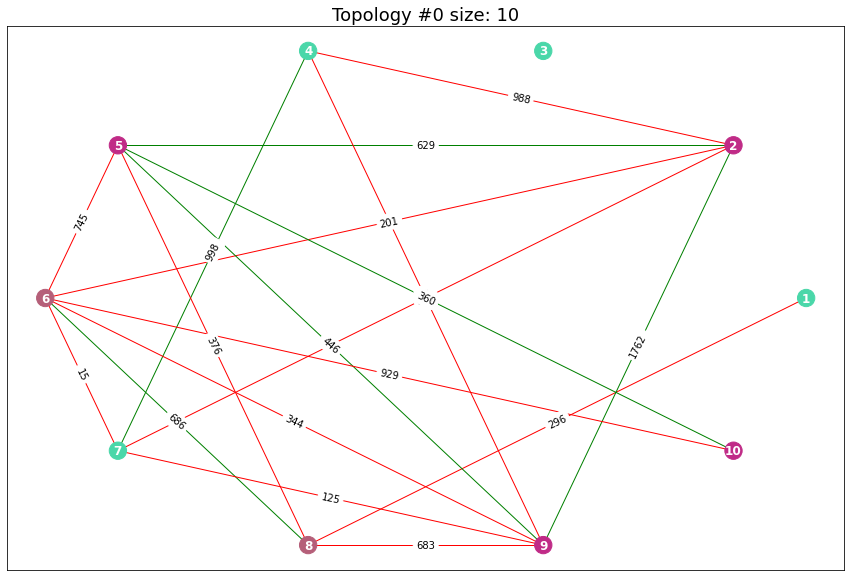

In [ ]:
# testing with a pedefined cluster just to see the output
draw_topology(top_10[0],'Topology #0 size: 10',np.array([0,1,0,0,1,2,0,2,1,1]),fig_size = (15,10));

## Running and visualizing the spectral clustering for a topology of size 10

For K =  {2,4,6,8,10}

In [ ]:
K = [2,4,6,8,10];

For topology number: 0



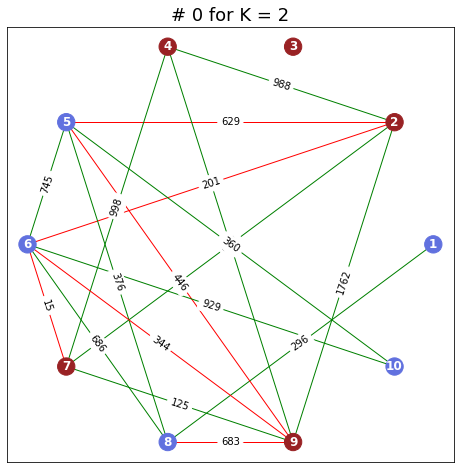

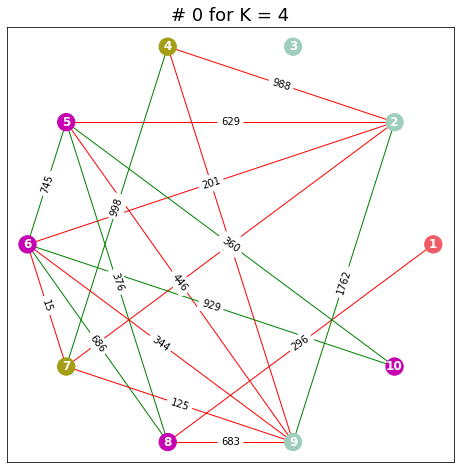

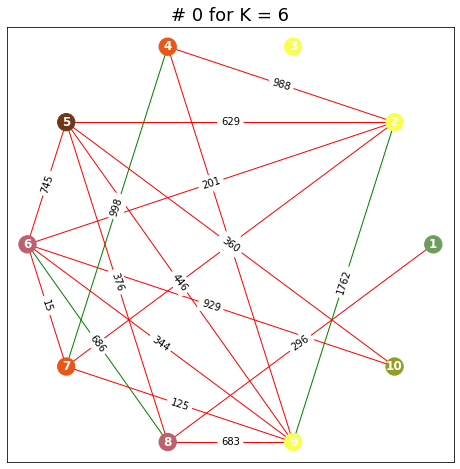

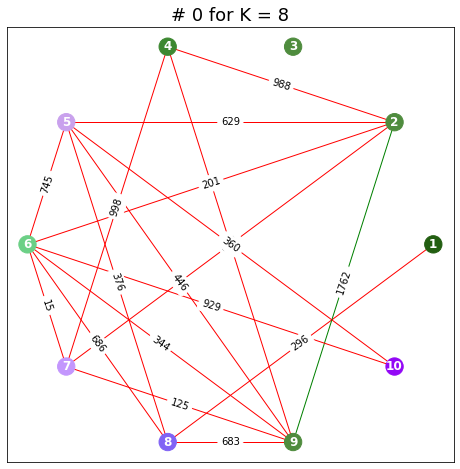

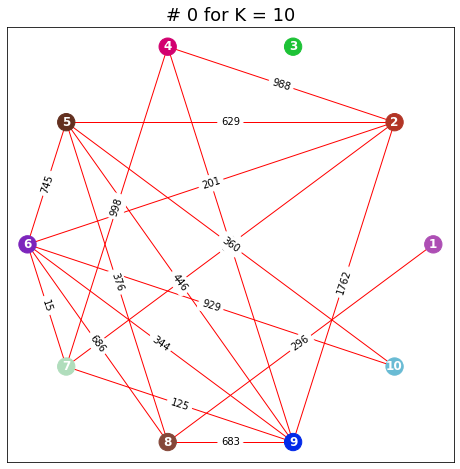

In [ ]:
print("For topology number: 0\n");
# obtaining eigen vectors for this topology spectral clustering
eig_vec = eig_vec_spec(top_10[0]);
for curr_K in K:
  curr_labels = spectral_cluster(eig_vec,curr_K);
  # visualizing the topology
  draw_topology(top_10[0],'# 0 for K = {}'.format(curr_K),curr_labels,(8,8));